In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from netuno import SSTHelper, SubserieDTW
from sklearn.multioutput import MultiOutputRegressor

In [28]:
f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [137]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

## Obtendo 5 pontos no mar
* Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [233]:
split_date = '2021-12-01'

chil = SubserieDTW(df, -22, -72, split_date, forecast_horizon=12)
medi = SubserieDTW(df, 36, 18, split_date, forecast_horizon=12)
atla = SubserieDTW(df, 0, -2, split_date, forecast_horizon=12)
enso = SubserieDTW(df, 20, -132, split_date, forecast_horizon=12)

indi = SubserieDTW(df, -56, 80, split_date, forecast_horizon=12)

Initializing
Lat: -22, Lon: -72
[0.63670594 0.62641585 0.73441344 ... 0.32512861 0.33221498 0.35176736]
[ 0.27341187  0.2528317   0.4688269  ... -0.34974277 -0.33557004
 -0.29646528]
Total length: 2038
1968 22
Train/test proportion: 0.9656526005888125/0.010794896957801767
Initializing
Lat: 36, Lon: 18
[0.22251053 0.19118312 0.1807629  ... 0.8891512  0.8264598  0.74953777]
[-0.55497897 -0.61763376 -0.6384742  ...  0.77830243  0.65291965
  0.49907553]
Total length: 2038
1968 22
Train/test proportion: 0.9656526005888125/0.010794896957801767
Initializing
Lat: 0, Lon: -2
[0.52938354 0.5255629  0.75756633 ... 0.40840217 0.48857298 0.575799  ]
[ 0.05876708  0.05112576  0.51513267 ... -0.18319565 -0.02285403
  0.15159798]
Total length: 2038
1968 22
Train/test proportion: 0.9656526005888125/0.010794896957801767
Initializing
Lat: 20, Lon: -132
[0.45452294 0.4209034  0.44970146 ... 0.66966057 0.7653795  0.7806142 ]
[-0.09095412 -0.15819317 -0.10059708 ...  0.33932114  0.530759
  0.5612284 ]
Total

### DS (Dynamic time warping + Support vector regression)
Implementando a técnica de forecasting apresentada pelo artigo [Improved Particle Swarm Optimization for Sea Surface Temperature Prediction](https://www.mdpi.com/1996-1073/13/6/1369) nomeada DS. Nesse algoritmo, para prever as próximas $x$ observações pegamos a janela referente as últimas observações que possuímos e procuramos subséries anteriores de mesmo tamanho utilizando DTW. Então, utilizamos as subséries mais próximas e as respectivas próximas $x$ observações encontradas para treinar um SVR.

### Queremos predizer a série em '?'
![img1](../resources/img1.png)
### Pegamos a janela mais próxima de tamanho $n$ e comparamos com a série em azul
![img2](../resources/img2.png)
### Pegamos as subséries mais próximas (x) e as observações seguintes (y)
![img3](../resources/img3.png)
### Treinamos um modelo regressor (SVR) para predizer os próximos valores utilizando x,y
![img4](../resources/img4.png)

In [201]:
from netuno import DSPipeline

### Indian Ocean

Initializing
Lat: -56, Lon: 80
[0.67455363 0.79580027 0.80168074 ... 0.36432543 0.30134213 0.32530108]
[ 0.34910727  0.59160054  0.6033615  ... -0.27134913 -0.39731574
 -0.34939784]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:04<00:00, 423.78it/s]


Obtained 1728 subseries
RMSE:  0.13080414631819917


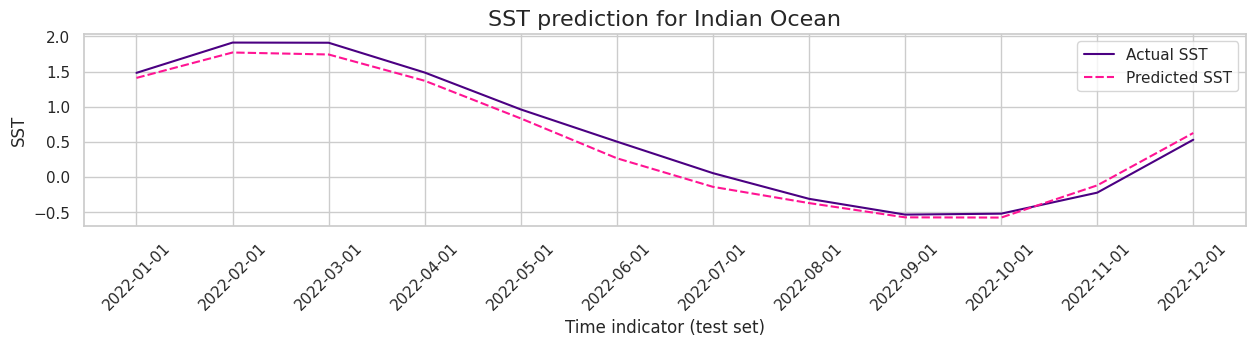

In [238]:
indi_pipeline = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
indi_pipeline.plot_predict('Indian Ocean', 'SVR')

### ENSO

Initializing
Lat: 20, Lon: -132
[0.45452294 0.4209034  0.44970146 ... 0.66966057 0.7653795  0.7806142 ]
[-0.09095412 -0.15819317 -0.10059708 ...  0.33932114  0.530759
  0.5612284 ]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:04<00:00, 385.71it/s]


Obtained 1728 subseries
RMSE:  0.395731210066807


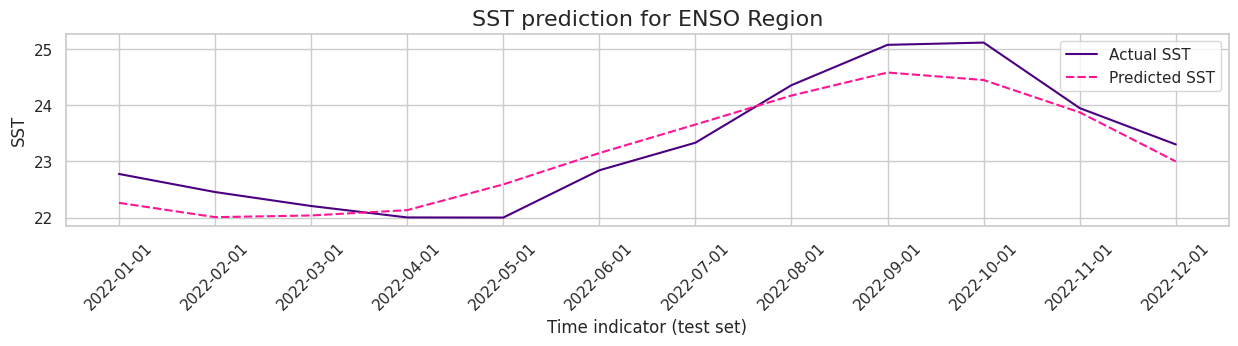

In [239]:
indi_pipeline = DSPipeline(df, 20, -132, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
indi_pipeline.plot_predict('ENSO Region', 'SVR')

### Mediterranean

Initializing
Lat: 36, Lon: 18
[0.22251053 0.19118312 0.1807629  ... 0.8891512  0.8264598  0.74953777]
[-0.55497897 -0.61763376 -0.6384742  ...  0.77830243  0.65291965
  0.49907553]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:04<00:00, 421.92it/s]


Obtained 1728 subseries
RMSE:  1.224077022197952


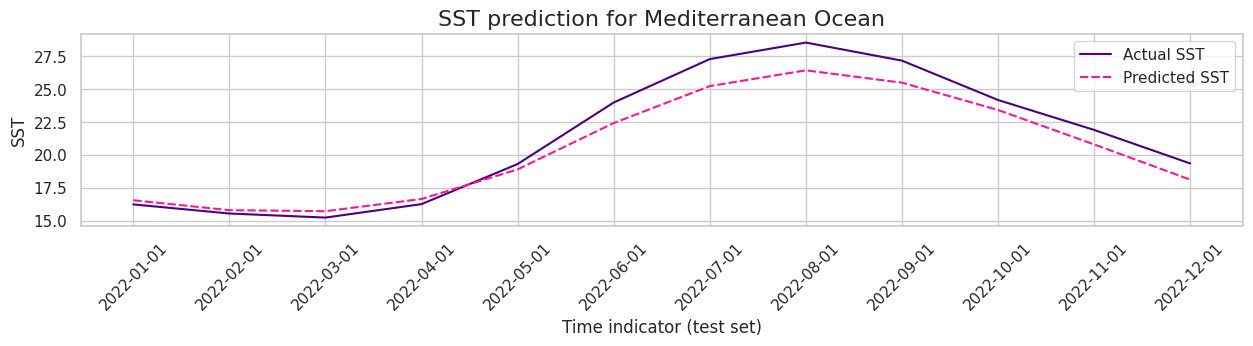

In [241]:
indi_pipeline = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
indi_pipeline.plot_predict('Mediterranean Ocean', 'SVR')

### Atlantic Ocean

Initializing
Lat: 0, Lon: -22
[0.48465556 0.6208495  0.7698381  ... 0.38051978 0.4714928  0.5528386 ]
[-0.03068888  0.24169898  0.5396762  ... -0.23896044 -0.05701441
  0.10567725]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:04<00:00, 409.24it/s]


Obtained 1728 subseries
RMSE:  0.3908008122426326


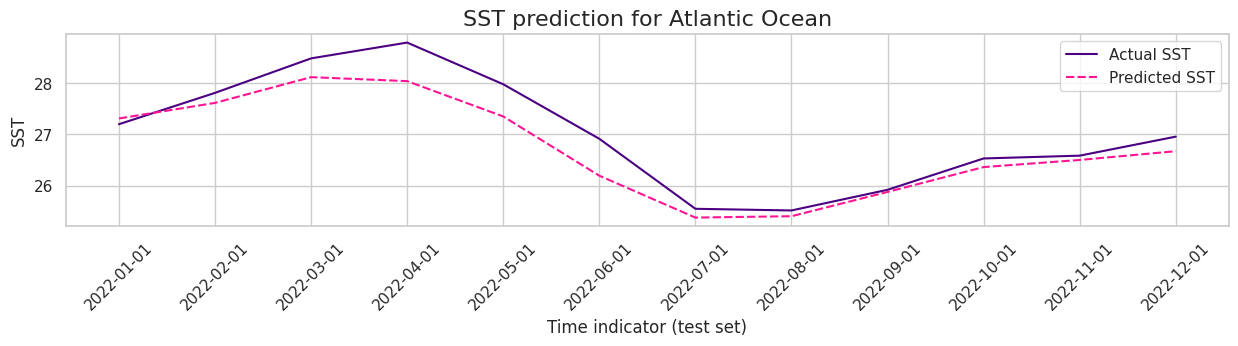

In [240]:
indi_pipeline = DSPipeline(df, 0, -22, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
indi_pipeline.plot_predict('Atlantic Ocean', 'SVR')

### Humboldt

Initializing
Lat: -22, Lon: -72
[0.63670594 0.62641585 0.73441344 ... 0.32512861 0.33221498 0.35176736]
[ 0.27341187  0.2528317   0.4688269  ... -0.34974277 -0.33557004
 -0.29646528]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:03<00:00, 500.59it/s]


Obtained 1728 subseries
RMSE:  0.5206175016250814


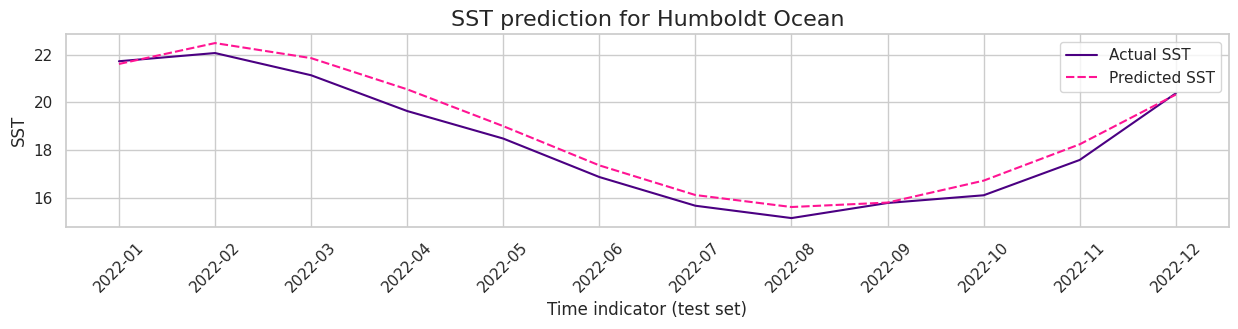

In [242]:
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
indi_pipeline.plot_predict('Humboldt Ocean', 'SVR')

In [214]:
pipeline1 = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", pipeline1.make_pipeline(1.0, 0.01))

pipeline2 = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", pipeline2.make_pipeline(1.0, 0.01))

pipeline3 = DSPipeline(df, 0, -2, split_date, forecast_horizon=12)
print("RMSE: ", pipeline3.make_pipeline(1.0, 0.01))


Initializing
Lat: -56, Lon: 80
[0.67455363 0.79580027 0.80168074 ... 0.36432543 0.30134213 0.32530108]
[ 0.34910727  0.59160054  0.6033615  ... -0.27134913 -0.39731574
 -0.34939784]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


  0%|          | 0/1729 [00:00<?, ?it/s]

100%|██████████| 1729/1729 [00:04<00:00, 369.58it/s]


Obtained 1729 subseries
RMSE:  0.2374193772612375
Initializing
Lat: 36, Lon: 18
[0.22251053 0.19118312 0.1807629  ... 0.8891512  0.8264598  0.74953777]
[-0.55497897 -0.61763376 -0.6384742  ...  0.77830243  0.65291965
  0.49907553]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 398.99it/s]


Obtained 1729 subseries
RMSE:  1.3170178034657616
Initializing
Lat: 0, Lon: -2
[0.52938354 0.5255629  0.75756633 ... 0.40840217 0.48857298 0.575799  ]
[ 0.05876708  0.05112576  0.51513267 ... -0.18319565 -0.02285403
  0.15159798]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 374.05it/s]

Obtained 1729 subseries
RMSE:  0.38402854640960427


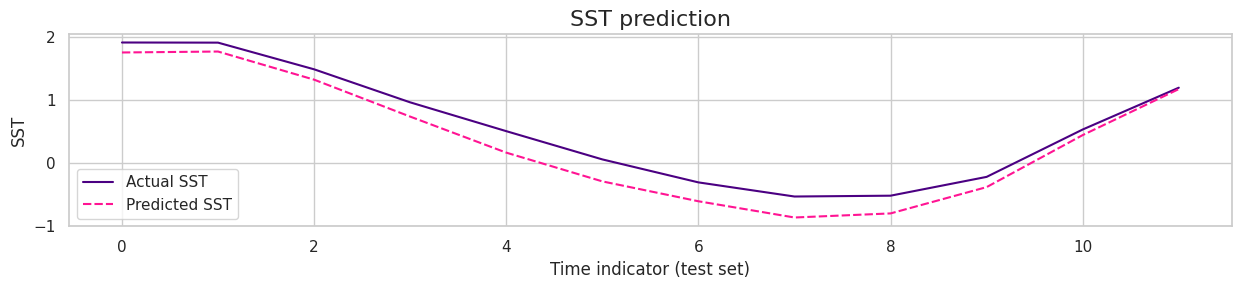

In [215]:
pipeline1.plot_predict()

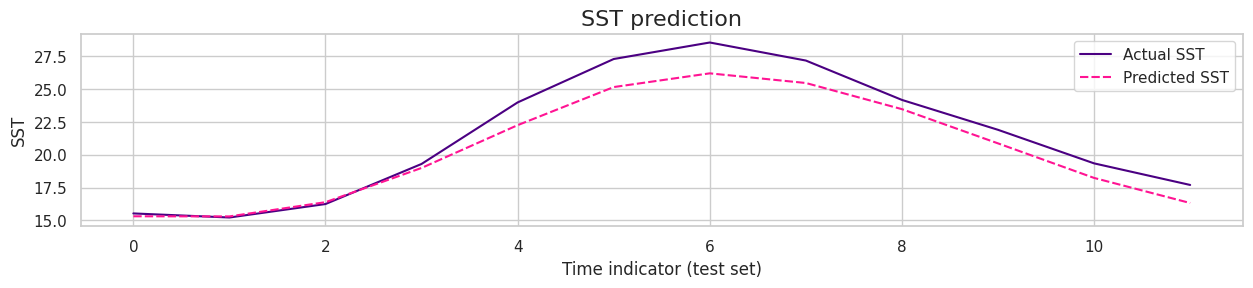

In [216]:
pipeline2.plot_predict()

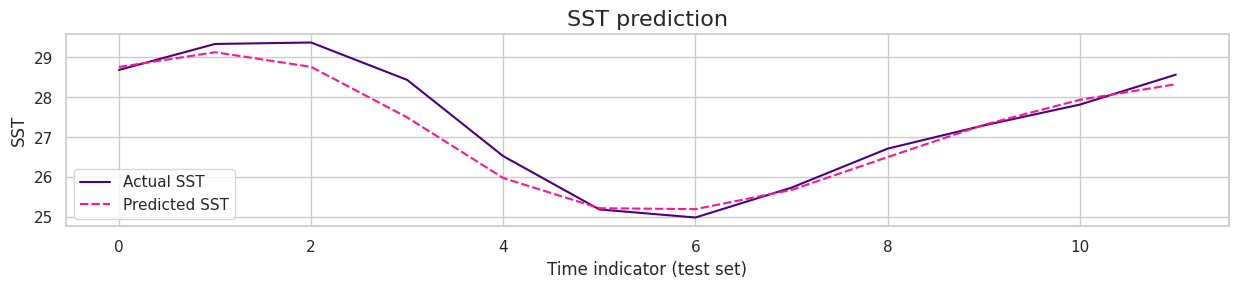

In [217]:
pipeline3.plot_predict()